In [1]:
import random
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import sys
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import networkx as nx 
from sklearn.manifold import TSNE

# Add the parent directory of 'src' to the Python path
sys.path.append('/ranjan/GT')  

# all modules will be reloaded automatically before executing any code.
%load_ext autoreload
%autoreload 2

import json 

# Import custom  modules
from src.data.data import LoadData, partition_graph
from src.data.embedding import mean_pooling, compute_laplacian_positional_embedding, compute_gcn_embeddings

from src.train.trainer import train_epoch, evaluate_network
from src.utils.utils import *
from src.utils.utils import set_seed
from src.data.data import LoadData, partition_graph
from src.data.embedding import mean_pooling, compute_laplacian_positional_embedding, compute_gcn_embeddings
from src.nets.load_net import gnn_model 
from src.utils.utils import set_seed
from src.train.trainer import collate_graphs, evaluate_network, train_epoch
# from src.utils.supergraph import  create_DGLSupergraph
from src.utils.supergraph import create_feature_dataset

/ranjan/GT/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open('/ranjan/GT/src/configs/default_config.json') as f:
    config = json.load(f)
    
params = config['params'] 

set_seed(params['seed'])   

DATASET_NAME = config['dataset']

net_params = config['net_params']


# Step 1: Loading Dataset

In [3]:
DATASET_NAME = 'Cora'
graph = LoadData(DATASET_NAME) 

# visualize_graph(graph)
graph


  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


Graph(num_nodes=2708, num_edges=10556,
      ndata_schemes={'feat': Scheme(shape=(1433,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'test_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'train_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={})

### Deatail Analysis of Train/Val/Test Nodes 

In [5]:
# Get source and destination nodes of all edges
src, dst = graph.edges()

# Print first 10 edges
for i in range(2708):
    print(f"Edge {i}: {src[i].item()} → {dst[i].item()}")


Edge 0: 0 → 633
Edge 1: 0 → 1862
Edge 2: 0 → 2582
Edge 3: 1 → 2
Edge 4: 1 → 652
Edge 5: 1 → 654
Edge 6: 2 → 1
Edge 7: 2 → 1986
Edge 8: 2 → 332
Edge 9: 2 → 1666
Edge 10: 2 → 1454
Edge 11: 3 → 2544
Edge 12: 4 → 2176
Edge 13: 4 → 1016
Edge 14: 4 → 1761
Edge 15: 4 → 1256
Edge 16: 4 → 2175
Edge 17: 5 → 1629
Edge 18: 5 → 2546
Edge 19: 5 → 1659
Edge 20: 6 → 1416
Edge 21: 6 → 1602
Edge 22: 6 → 1042
Edge 23: 6 → 373
Edge 24: 7 → 208
Edge 25: 8 → 281
Edge 26: 8 → 1996
Edge 27: 8 → 269
Edge 28: 9 → 2614
Edge 29: 9 → 723
Edge 30: 10 → 476
Edge 31: 10 → 2545
Edge 32: 11 → 1655
Edge 33: 11 → 1839
Edge 34: 12 → 2661
Edge 35: 12 → 1001
Edge 36: 12 → 1318
Edge 37: 12 → 2662
Edge 38: 13 → 1810
Edge 39: 13 → 1701
Edge 40: 14 → 2034
Edge 41: 14 → 2075
Edge 42: 14 → 158
Edge 43: 14 → 2077
Edge 44: 14 → 2668
Edge 45: 15 → 2367
Edge 46: 15 → 1093
Edge 47: 15 → 1090
Edge 48: 15 → 1271
Edge 49: 16 → 2444
Edge 50: 16 → 1632
Edge 51: 16 → 970
Edge 52: 16 → 2642
Edge 53: 17 → 24
Edge 54: 17 → 2140
Edge 55: 17 → 1

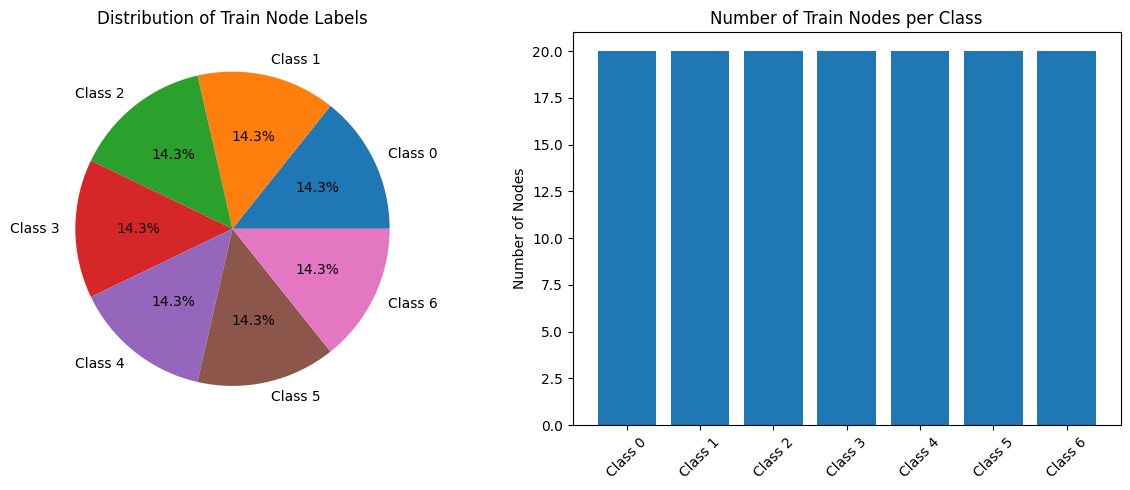


=== Train Set Statistics ===
Total number of train nodes: 140
Percentage of train nodes: 5.17%
Class distribution: [(0, 20), (1, 20), (2, 20), (3, 20), (4, 20), (5, 20), (6, 20)]



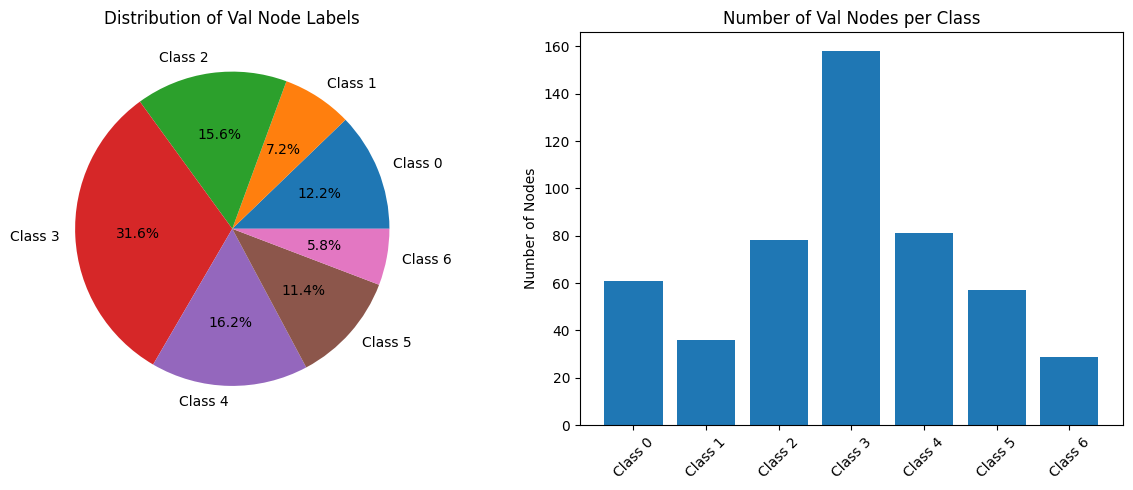


=== Val Set Statistics ===
Total number of val nodes: 500
Percentage of val nodes: 18.46%
Class distribution: [(0, 61), (1, 36), (2, 78), (3, 158), (4, 81), (5, 57), (6, 29)]



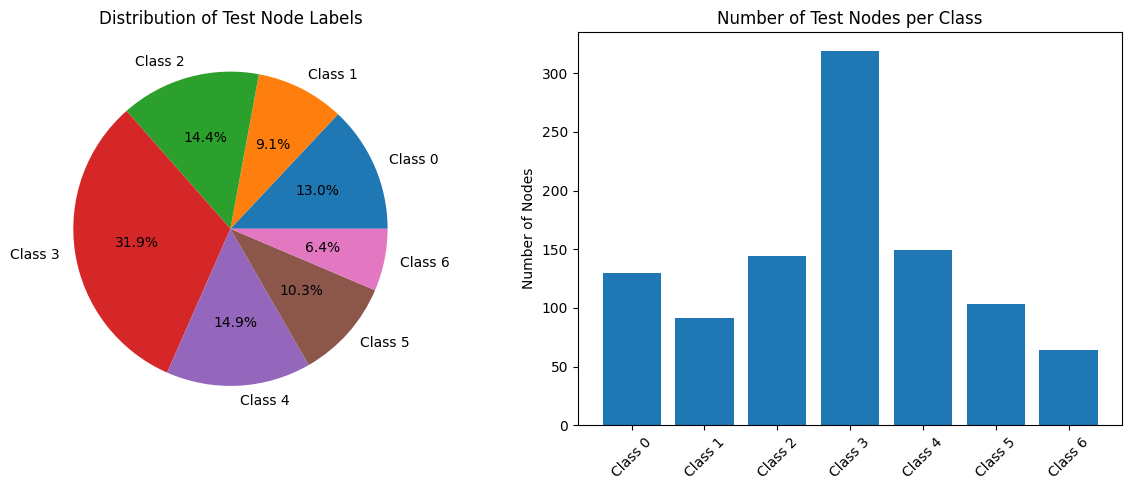


=== Test Set Statistics ===
Total number of test nodes: 1000
Percentage of test nodes: 36.93%
Class distribution: [(0, 130), (1, 91), (2, 144), (3, 319), (4, 149), (5, 103), (6, 64)]



In [4]:
def analyze_node_distribution(graph, split_type):
	"""
	Analyze and visualize the distribution of nodes for a specific split type.
	Args:
		graph: DGL graph object
		split_type: str, one of ['train', 'val', 'test']
	"""
	# Get the mask and labels for the specified split
	mask = graph.ndata[f'{split_type}_mask']
	labels = graph.ndata['label'][mask]
	
	# Create figure for visualization
	plt.figure(figsize=(12, 5))
	
	# Pie chart
	plt.subplot(1, 2, 1)
	unique_labels = torch.unique(labels)
	label_counts = [(l.item(), (labels == l).sum().item()) for l in unique_labels]
	
	plt.pie([count for _, count in label_counts],
			labels=[f'Class {label}' for label, _ in label_counts],
			autopct='%1.1f%%')
	plt.title(f'Distribution of {split_type.capitalize()} Node Labels')
	
	# Bar plot
	plt.subplot(1, 2, 2)
	plt.bar([f'Class {label}' for label, _ in label_counts],
			[count for _, count in label_counts])
	plt.title(f'Number of {split_type.capitalize()} Nodes per Class')
	plt.xticks(rotation=45)
	plt.ylabel('Number of Nodes')
	
	plt.tight_layout()
	plt.show()
	
	# Print statistics
	print(f"\n=== {split_type.capitalize()} Set Statistics ===")
	print(f"Total number of {split_type} nodes: {mask.sum().item()}")
	print(f"Percentage of {split_type} nodes: {100 * mask.sum().item() / len(mask):.2f}%")
	print(f"Class distribution: {label_counts}")
	print()



# Analyze distribution for each split
analyze_node_distribution(graph, 'train')  # For training set
analyze_node_distribution(graph, 'val')    # For validation set
analyze_node_distribution(graph, 'test')   # For test set 

# Step 2: Partition the graph into subgraphs

In [5]:

subgraphs = partition_graph(graph, num_parts=config['data']['num_parts'])

Convert a graph into a bidirected graph: 0.001 seconds, peak memory: 11.311 GB
Construct multi-constraint weights: 0.000 seconds, peak memory: 11.311 GB
Metis partitioning: 0.012 seconds, peak memory: 11.311 GB
Graph partitioned into 100 subgraphs.


[14:46:53] /opt/dgl/src/graph/transform/metis_partition_hetero.cc:89: Partition a graph with 2708 nodes and 10556 edges into 100 parts and get 1497 edge cuts


In [6]:
# subgraphs = partition_graph(graph, num_parts=config['data']['num_parts'])
subgraphs[0]

Graph(num_nodes=28, num_edges=66,
      ndata_schemes={'feat': Scheme(shape=(1433,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'test_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'part_id': Scheme(shape=(), dtype=torch.int64), '_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)})

AttributeError: 'DGLGraph' object has no attribute 'edge_index'

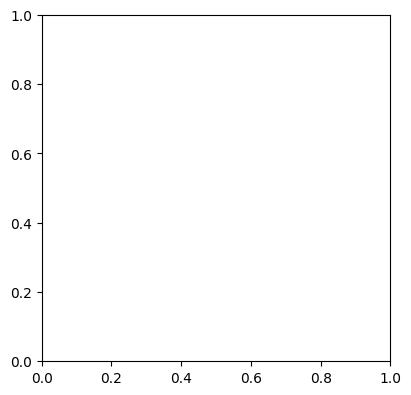

In [8]:
num_plots = 1
visualize_subgraphs(subgraphs, num_plots=num_plots)

---

# Step 3: Compute embeddings and track mask information

In [4]:
# Initialize lists for storing embeddings and metadata
subgraph_embeddings, lpe_embeddings = [], []
node_labels, node_counts, node_indices = [], [], []
start_idx = 0
subgraph_embeddings_without_mean=[]

# Process each subgraph
for i, subgraph in enumerate(subgraphs):
    num_nodes = subgraph.number_of_nodes()
    node_indices.append(torch.arange(start_idx, start_idx + num_nodes))
    start_idx += num_nodes
        
    # Compute embeddings
    gcn_embeddings = compute_gcn_embeddings(
            subgraph, 
            input_dim=config['gcn']['input_dim'],
            hidden_dim=config['gcn']['hidden_dim'],
            output_dim=config['gcn']['output_dim']
        )
    
    
    
    lpe = compute_laplacian_positional_embedding(subgraph, embedding_dim=config['gcn']['output_dim'])
        
    # Store results
    subgraph_embeddings.append(mean_pooling(gcn_embeddings))
    subgraph_embeddings_without_mean.append(gcn_embeddings)
    lpe_embeddings.append(mean_pooling(lpe))
        
    # Get labels from DGL graph
    print(f"\nSubgraph {i} : label ",subgraph.ndata['label'])
    node_labels.append(subgraph.ndata['label'])
    node_counts.append(num_nodes)
        
    if (i + 1) % 10 == 0:
        print(f"Processed {i+1}/{len(subgraphs)} subgraphs")


# Stack and move to device
subgraph_embeddings = torch.stack(subgraph_embeddings)
lpe_embeddings = torch.stack(lpe_embeddings)

node_labels = torch.cat(node_labels, dim=0)
node_counts = torch.tensor(node_counts)

NameError: name 'subgraphs' is not defined

In [1]:
node_labels

NameError: name 'node_labels' is not defined

In [133]:
subgraph_embeddings[0], subgraph_embeddings[0].shape

(tensor([ 6.2860e-04,  2.9602e-03, -4.0386e-03,  9.9350e-06, -1.0687e-03,
         -7.1242e-03, -1.7687e-04, -2.5998e-03,  6.2170e-03,  6.4152e-03,
         -1.8921e-03,  5.7498e-03, -3.5012e-03, -2.5908e-03, -8.2277e-03,
         -2.1572e-03]),
 torch.Size([16]))

In [110]:
subgraph_embeddings, subgraph_embeddings.shape

(tensor([[ 6.2860e-04,  2.9602e-03, -4.0386e-03,  ..., -2.5908e-03,
          -8.2277e-03, -2.1572e-03],
         [-6.8966e-03, -4.9273e-03,  6.6631e-03,  ..., -8.4420e-05,
          -8.9003e-03, -3.7443e-03],
         [ 2.5325e-03, -4.4277e-04,  2.8404e-03,  ...,  4.7764e-04,
          -9.9678e-05, -5.2599e-03],
         ...,
         [-1.1073e-03, -5.2755e-03,  5.4925e-04,  ..., -1.5405e-03,
           5.6819e-03,  7.8911e-04],
         [ 2.1274e-03, -1.5071e-03,  3.6853e-03,  ...,  3.6901e-03,
           2.7280e-04,  2.9424e-03],
         [-1.3398e-05, -5.8768e-04, -3.1845e-04,  ..., -1.7948e-04,
           2.6340e-03, -5.7983e-04]]),
 torch.Size([100, 16]))

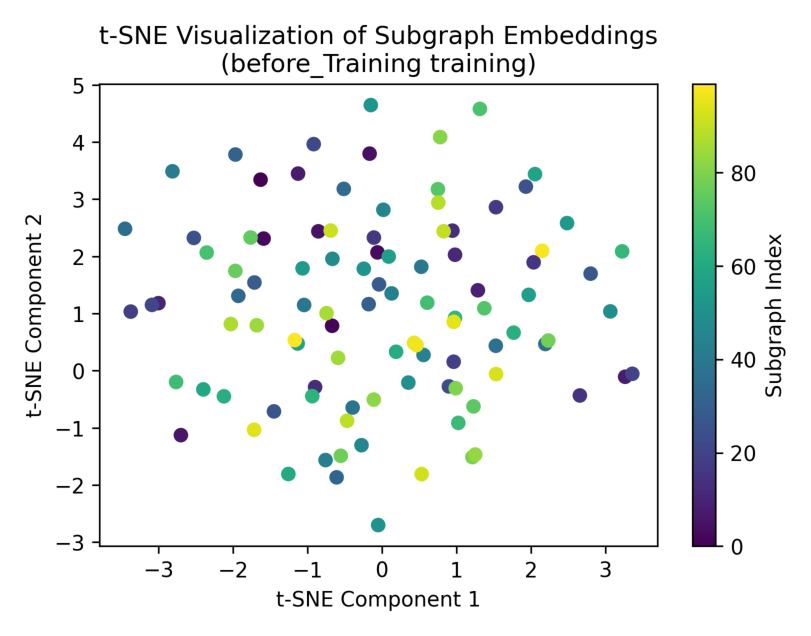

In [93]:
visulaize_subgraph_embedding(subgraph_embeddings,phase='before_Training')

img = plt.imread('/ranjan/GT/out/visualize/subgraph_embeddings_before_Training.png')
plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.axis('off')
plt.show()

In [138]:
from src.utils.supergraph import create_feature_dataset

combined_embedding = subgraph_embeddings + lpe_embeddings
dataset = create_feature_dataset(combined_embedding)


 ------ Feature Dataset Statistics:------------
Number of subgraphs: 100
Feature dimension: 16
Device: cpu


In [152]:
"""
    VIEWING MODEL CONFIG AND PARAMS
"""
def view_model_param(MODEL_NAME, net_params):
    model = gnn_model(MODEL_NAME, net_params)
    total_param = 0
    print("MODEL DETAILS:\n")
    #print(model)
    for param in model.parameters():
        # print(param.data.size())
        total_param += np.prod(list(param.data.size()))
    print('MODEL/Total parameters:', MODEL_NAME, total_param)
    return total_param

def gpu_setup(use_gpu, gpu_id):
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)  
    device = torch.device("cuda" if torch.cuda.is_available() and use_gpu else "cpu")
    if device.type == "cuda":
        print('cuda available with GPU:', torch.cuda.get_device_name(0))
    else:
        print('cuda not available, using CPU')
    return device



MODEL_NAME = config['model']
# Cora
net_params['in_dim'] = config['gcn']['output_dim']  # This is 16 from GCN output
net_params['n_classes'] = 7

- `torch.stack(subgraph_embeddings)` is stacking a list of PyTorch tensors along a new dimension. 
- This operation creates a new tensor by concatenating the input tensors along the specified dimension. 
- In this case, `subgraph_embeddings` is a list of PyTorch tensors, and `torch.stack(subgraph_embeddings)` will stack these tensors along a new dimension to create a single tensor.
